# Report Código CE
## Juan Leal Aliaga - 100473223

###
---
#### Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import time
import random
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')

# Importar las funciones y librerías adicionales
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge

#### Import EvolutionaryOptimizer

In [2]:
from evopt import EvolutionaryOptimizer

## Pruebas con los diferentes datasets

#### California Housing Dataset

In [3]:
df = pd.read_csv('../../california.csv')

# CASO DIABETES
#X = df.drop('target', axis=1).values
#y = df['target'].values

# CASO CALIFORNIA (descomentar si se usa otro dataset)
X = df.drop('MedHouseVal', axis=1).values
y = df['MedHouseVal'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

print(f"\n{'='*70}")
print(f"EVALUACIÓN DEL SISTEMA")
print(f"{'='*70}")
print(f"Dataset: {X.shape[0]} instancias, {X.shape[1]} features")
print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"{'='*70}\n")

# ========================================================================
# BASELINE: Modelo sin optimización
# ========================================================================
print(f"\n{'='*70}")
print(f"BASELINE (Sin Optimización)")
print(f"{'='*70}")

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline = Ridge(alpha=1.0, random_state=42)
baseline.fit(X_train, y_train)
baseline_preds = baseline.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_mse = mean_squared_error(y_test, baseline_preds)

print(f"MAE: {baseline_mae:.4f}")
print(f"MSE: {baseline_mse:.4f}")
print(f"Features utilizadas: {X_train.shape[1]}")

# ========================================================================
# OPTIMIZACIÓN CON PROGRAMACIÓN GENÉTICA + FEATURE SELECTION
# ========================================================================
print(f"\n{'='*70}")
print(f"OPTIMIZACIÓN EVOLUTIVA")
print(f"{'='*70}")

# Crear optimizador
gp_optimizer = EvolutionaryOptimizer(
maxtime=3600,  # 20 minutos (ajusta según necesites)
)

# Entrenar el optimizador (aprende transformaciones)
gp_optimizer.fit(X_train, y_train)

# Transformar los datos (aplicar las transformaciones aprendidas)
X_train_optimized = gp_optimizer.transform(X_train)
X_test_optimized = gp_optimizer.transform(X_test)

if gp_optimizer.feature_selection_ is not None:
    n_selected = np.sum(gp_optimizer.feature_selection_)
    n_total = len(gp_optimizer.feature_selection_)
    print(f"Features seleccionadas: {n_selected}/{n_total}")
    
    # Mostrar cuáles features se seleccionaron
    print(f"\nFeatures seleccionadas:")
    selected_indices = np.where(gp_optimizer.feature_selection_)[0]
    for idx in selected_indices:
        if idx < X.shape[1]:
            print(f"  X{idx} (original)")
        else:
            tree_idx = idx - X.shape[1]
            if tree_idx < len(gp_optimizer.best_trees_):
                print(f"  {gp_optimizer.best_trees_[tree_idx].to_string()} (generada)")
# Modelos adicionales para probar
additional_models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(n_jobs=-1, random_state=42, verbosity=0),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    'BayesianRidge': BayesianRidge(),
    'HuberRegressor': HuberRegressor(),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'Bagging': BaggingRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

print(f"\n{'='*80}")
print("PROBANDO MODELOS ADICIONALES")
print(f"{'='*80}")

results = []

for name, model in additional_models.items():
    try:
        print(f"\nProbando {name}...")
        
        # Baseline
        model_baseline = clone(model)
        model_baseline.fit(X_train, y_train)
        baseline_preds = model_baseline.predict(X_test)
        
        baseline_mae = mean_absolute_error(y_test, baseline_preds)
        baseline_mse = mean_squared_error(y_test, baseline_preds)
        
        # Con optimización
        model_optimized = clone(model)
        model_optimized.fit(X_train_optimized, y_train)
        optimized_preds = model_optimized.predict(X_test_optimized)
        
        optimized_mae = mean_absolute_error(y_test, optimized_preds)
        optimized_mse = mean_squared_error(y_test, optimized_preds)
        
        # Mejoras
        mae_improvement = ((baseline_mae - optimized_mae) / baseline_mae * 100)
        mse_improvement = ((baseline_mse - optimized_mse) / baseline_mse * 100)
        
        results.append({
            'Modelo': name,
            'MAE_Base': baseline_mae,
            'MAE_Opt': optimized_mae,
            'Mejora_MAE': mae_improvement,
            'MSE_Base': baseline_mse,
            'MSE_Opt': optimized_mse,
            'Mejora_MSE': mse_improvement
        })
        
        print(f"  MAE: {baseline_mae:.4f} → {optimized_mae:.4f} ({mae_improvement:+.2f}%)")
        print(f"  MSE: {baseline_mse:.4f} → {optimized_mse:.4f} ({mse_improvement:+.2f}%)")
        
    except Exception as e:
        print(f"  Error: {e}")
        continue

# Mostrar resumen
print(f"\n{'='*100}")
print("RESUMEN COMPLETO - TODOS LOS MODELOS")
print(f"{'='*100}")

df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values('Mejora_MSE', ascending=False)

print(f"{'Modelo':<15} {'MAE Base':<10} {'MAE Opt':<10} {'Mejora MAE':<12} {'MSE Base':<10} {'MSE Opt':<10} {'Mejora MSE':<12}")
print("-" * 100)

for _, row in df_sorted.iterrows():
    print(f"{row['Modelo']:<15} {row['MAE_Base']:<10.4f} {row['MAE_Opt']:<10.4f} "
          f"{row['Mejora_MAE']:+<12.2f}% {row['MSE_Base']:<10.4f} {row['MSE_Opt']:<10.4f} "
          f"{row['Mejora_MSE']:+<12.2f}%")

# Estadísticas finales
print(f"\n{'='*60}")
print("ESTADÍSTICAS GENERALES")
print(f"{'='*60}")
print(f"Modelos que mejoraron MAE: {len(df_sorted[df_sorted['Mejora_MAE'] > 0])}/{len(df_sorted)}")
print(f"Modelos que mejoraron MSE: {len(df_sorted[df_sorted['Mejora_MSE'] > 0])}/{len(df_sorted)}")
print(f"Mejor mejora MAE: {df_sorted['Mejora_MAE'].max():.2f}% ({df_sorted.loc[df_sorted['Mejora_MAE'].idxmax(), 'Modelo']})")
print(f"Mejor mejora MSE: {df_sorted['Mejora_MSE'].max():.2f}% ({df_sorted.loc[df_sorted['Mejora_MSE'].idxmax(), 'Modelo']})")
print(f"Mejora promedio MAE: {df_sorted['Mejora_MAE'].mean():.2f}%")
print(f"Mejora promedio MSE: {df_sorted['Mejora_MSE'].mean():.2f}%")


EVALUACIÓN DEL SISTEMA
Dataset: 20640 instancias, 8 features
Train: 16512 | Test: 4128


BASELINE (Sin Optimización)
MAE: 0.5332
MSE: 0.5558
Features utilizadas: 8

OPTIMIZACIÓN EVOLUTIVA
Juan Leal Aliaga - 100473223

PROGRAMACIÓN GENÉTICA CON CONTROL ESTRICTO DE TIEMPO

Iniciando Programación Genética...
Gen 1 - MEJORA! CV MSE: 0.3645 | CV MAE: 0.4256 | Tiempo: 220.3s
Gen 2 - MEJORA! CV MSE: 0.3638 | CV MAE: 0.4251 | Tiempo: 650.8s
Gen 3 - MEJORA! CV MSE: 0.3497 | CV MAE: 0.4127 | Tiempo: 975.2s
Gen 6 - MEJORA! CV MSE: 0.3405 | CV MAE: 0.4045 | Tiempo: 1929.5s
    Timeout en evaluación individual 44/60
  Timeout en evaluación de generación 8
Programación Genética completada: 8 generaciones en 2457.3s
Mejores árboles encontrados:
  1: tanh(square(X0))
  2: tanh((X7 add X6))
  3: ((sqrt(X6) sub X3) add tanh(tanh(X5)))
  4: (tanh(X5) div log(X4))
FEATURE SELECTION CON CONTROL ESTRICTO DE TIEMPO
Aplicando selección evolutiva sobre 12 features...
✓ Selección completada: 10/12 features
  M

✅ Carga completada desde un único CSV.
Objetivo (target): MedHouseVal
Features numéricas usadas: 8
Shapes → X_train: (15480, 8) | X_test: (5160, 8)

✅ Resultados del benchmark (usando resultados anteriores):


,Modelo,MAE_Base,MAE_Opt,Mejora_MAE,MSE_Base,MSE_Opt,Mejora_MSE
0,Ridge,0.533204,0.473830,11.135269,0.555803,0.436131,21.531386
1,LinearRegression,0.533200,0.471791,11.517166,0.555892,0.433929,21.939990
2,RandomForest,0.327543,0.309014,5.656831,0.255368,0.229251,10.227505
3,SVR,0.859951,0.453205,47.298740,1.332012,0.423347,68.217476
4,XGBoost,0.309573,0.299820,3.150514,0.222590,0.207784,6.651823
5,GradientBoosting,0.371643,0.352680,5.102353,0.293997,0.271519,7.645760
6,Lasso,0.761578,0.906069,-18.972482,0.938034,1.310696,-39.728029
7,ElasticNet,0.676284,0.838792,-24.029575,0.764556,1.126427,-47.330925
8,BayesianRidge,0.533215,0.471891,11.500801,0.555586,0.433984,21.887258
9,HuberRegressor,0.587587,0.464548,20.939655,0.711916,0.446348,37.303346



🎨 Generando gráfico de paridad elegante...


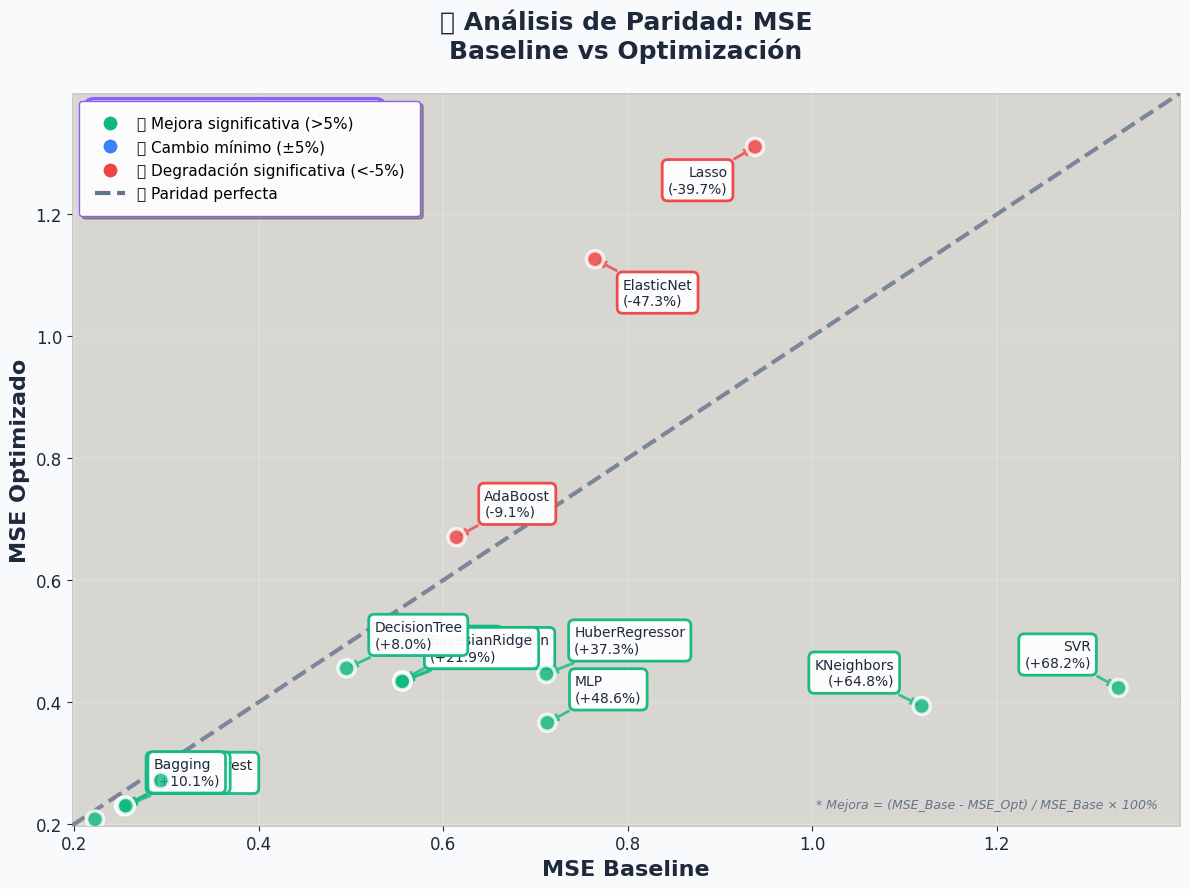

In [4]:
# ===============================================
# 📥 Carga de california.csv (split automático train/test)
# ===============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 👉 Cambia la ruta si está en otra carpeta
PATH = "../../california.csv"

# Intentos típicos de nombre de objetivo
TARGET_CANDIDATES = [
    "MedHouseVal",
]

df = pd.read_csv(PATH)

# ---- Detectar columna objetivo ----
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    # Si no se encuentra, usamos la última columna como objetivo (aviso)
    target_col = df.columns[-1]
    print(f"⚠️ No se encontró una columna objetivo conocida. Uso '{target_col}' (última del CSV).")

# Convertir a numérico por seguridad
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

# ---- Selección de features numéricas ----
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

# ---- Crear X, y ----
X = df[num_cols].copy()
y = df[target_col].values

# ---- Split 75% / 25% ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ---- Imputación simple de NaNs ----
medians = X_train.median(numeric_only=True)
X_train = X_train.fillna(medians)
X_test  = X_test.fillna(medians)

print("✅ Carga completada desde un único CSV.")
print(f"Objetivo (target): {target_col}")
print(f"Features numéricas usadas: {len(num_cols)}")
print("Shapes → X_train:", X_train.shape, "| X_test:", X_test.shape)

# ==========================================================
# 🔥 EVOPT Full Benchmark + Visual Gallery ELEGANTE
# ==========================================================
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings("ignore")

# ===== Imports ML =====
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import (
    LinearRegression, HuberRegressor, Ridge, Lasso, ElasticNet, BayesianRidge
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
)
from sklearn.svm import SVR
from xgboost import XGBRegressor

# ===== Try to import your optimizer from evopt.py =====
EvolutionaryOptimizer = None
try:
    from evopt import EvolutionaryOptimizer as _EO
    EvolutionaryOptimizer = _EO
except Exception as e:
    print("ℹ️ No se pudo importar EvolutionaryOptimizer desde evopt.py (no pasa nada).")
    print("   Detalle:", e)

# ==========================================================
# 🎨 GRÁFICO DE PARIDAD ELEGANTE - FUNCIÓN PRINCIPAL
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

def create_elegant_parity_plot(df_results, metric="MSE"):
    """
    Crea un gráfico de paridad elegante y moderno para comparar MSE Base vs Optimizado
    """
    # Configurar el estilo elegante
    plt.style.use('default')
    sns.set_palette("husl")

    # Configuración de colores elegantes
    colors = {
        'background': '#f8fafc',
        'grid': '#e2e8f0',
        'diagonal': '#64748b',
        'scatter': '#3b82f6',
        'accent': '#8b5cf6',
        'text': '#1e293b',
        'improvement': '#10b981',
        'degradation': '#ef4444'
    }

    base_col = f"{metric}_Base"
    opt_col = f"{metric}_Opt"

    if base_col not in df_results.columns or opt_col not in df_results.columns:
        print(f"❌ Columnas {base_col} o {opt_col} no encontradas")
        return

    # Filtrar valores válidos
    valid_mask = ~(pd.isna(df_results[base_col]) | pd.isna(df_results[opt_col]))
    df_clean = df_results[valid_mask].copy()

    if df_clean.empty:
        print("❌ No hay datos válidos para el gráfico")
        return

    x = df_clean[base_col].values
    y = df_clean[opt_col].values
    models = df_clean["Modelo"].values

    # Crear figura con diseño elegante
    fig, ax = plt.subplots(figsize=(12, 9))
    fig.patch.set_facecolor(colors['background'])
    ax.set_facecolor(colors['background'])

    # Calcular límites con margen
    min_val = min(x.min(), y.min()) * 0.95
    max_val = max(x.max(), y.max()) * 1.05

    # Crear gradiente de colores basado en la mejora
    improvements = 100 * (x - y) / x
    scatter_colors = []
    sizes = []
    for imp in improvements:
        if imp > 5:  # Mejora significativa
            scatter_colors.append(colors['improvement'])
            sizes.append(150)
        elif imp < -5:  # Degradación significativa
            scatter_colors.append(colors['degradation'])
            sizes.append(150)
        else:  # Cambio mínimo
            scatter_colors.append(colors['scatter'])
            sizes.append(120)

    # Scatter plot principal con diseño elegante
    scatter = ax.scatter(x, y,
                        c=scatter_colors,
                        s=sizes,
                        alpha=0.8,
                        edgecolors='white',
                        linewidths=2.5,
                        zorder=5)

    # Línea diagonal de paridad con estilo elegante
    diagonal_line = ax.plot([min_val, max_val], [min_val, max_val],
                           linestyle='--',
                           color=colors['diagonal'],
                           linewidth=3,
                           alpha=0.8,
                           zorder=3,
                           label='Paridad perfecta')

    # Zona de mejora (debajo de la diagonal)
    ax.fill_between([min_val, max_val], [min_val, min_val], [max_val, max_val],
                    alpha=0.15, color=colors['improvement'],
                    label='Zona de mejora', zorder=1)

    # Zona de degradación (encima de la diagonal)
    ax.fill_between([min_val, max_val], [min_val, min_val], [max_val, max_val],
                    alpha=0.15, color=colors['degradation'],
                    label='Zona de degradación', zorder=1)


    # Configurar límites y grid elegante
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.grid(True, alpha=0.4, color=colors['grid'], linewidth=1.2)

    # Etiquetas y título con tipografía elegante
    ax.set_xlabel(f'{metric} Baseline', fontsize=16, fontweight='bold', color=colors['text'])
    ax.set_ylabel(f'{metric} Optimizado', fontsize=16, fontweight='bold', color=colors['text'])
    ax.set_title(f'🎯 Análisis de Paridad: {metric}\nBaseline vs Optimización',
                fontsize=18, fontweight='bold', color=colors['text'], pad=25)

    # Personalizar ticks
    ax.tick_params(colors=colors['text'], labelsize=12)

    # Agregar anotaciones para modelos destacados
    for i, (xi, yi, model) in enumerate(zip(x, y, models)):
        improvement = improvements[i]
        if abs(improvement) > 8:  # Solo anotar mejoras/degradaciones muy significativas
            offset_x = (max_val - min_val) * 0.025
            offset_y = (max_val - min_val) * 0.025

            # Determinar posición de la anotación para evitar solapamiento
            if xi > (min_val + max_val) / 2:
                offset_x = -offset_x
                ha = 'right'
            else:
                ha = 'left'

            if yi > (min_val + max_val) / 2:
                offset_y = -offset_y
                va = 'top'
            else:
                va = 'bottom'

            ax.annotate(f'{model}\n({improvement:+.1f}%)',
                       xy=(xi, yi),
                       xytext=(xi + offset_x, yi + offset_y),
                       fontsize=10,
                       color=colors['text'],
                       ha=ha,
                       va=va,
                       bbox=dict(boxstyle='round,pad=0.4',
                                facecolor='white',
                                edgecolor=scatter_colors[i],
                                alpha=0.95,
                                linewidth=2),
                       arrowprops=dict(arrowstyle='->',
                                     color=scatter_colors[i],
                                     alpha=0.8,
                                     linewidth=2))

    # Leyenda elegante
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['improvement'],
                   markersize=12, label='🟢 Mejora significativa (>5%)', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['scatter'],
                   markersize=12, label='🔵 Cambio mínimo (±5%)', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['degradation'],
                   markersize=12, label='🔴 Degradación significativa (<-5%)', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], linestyle='--', color=colors['diagonal'],
                   linewidth=3, label='📏 Paridad perfecta')
    ]

    ax.legend(handles=legend_elements,
             loc='upper left',
             frameon=True,
             fancybox=True,
             shadow=True,
             framealpha=0.98,
             facecolor='white',
             edgecolor=colors['accent'],
             borderpad=1,
             fontsize=11)

    # Estadísticas del gráfico en una caja elegante
    n_improved = sum(improvements > 0)
    n_total = len(improvements)
    avg_improvement = np.mean(improvements)
    best_improvement = np.max(improvements)
    worst_change = np.min(improvements)

    stats_text = f"""📊 Estadísticas de Rendimiento:
• Modelos mejorados: {n_improved}/{n_total} ({100*n_improved/n_total:.1f}%)
• Mejora promedio: {avg_improvement:+.2f}%
• Mejor mejora: {best_improvement:+.2f}%
• Peor cambio: {worst_change:+.2f}%"""

    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.6',
                     facecolor='white',
                     edgecolor=colors['accent'],
                     alpha=0.98,
                     linewidth=2.5))

    # Remover spines para un look más limpio
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Agregar nota metodológica
    method_note = "* Mejora = (MSE_Base - MSE_Opt) / MSE_Base × 100%"
    ax.text(0.98, 0.02, method_note,
            transform=ax.transAxes,
            fontsize=9,
            style='italic',
            color=colors['diagonal'],
            ha='right',
            va='bottom')

    plt.tight_layout()
    plt.show()

# ==========================================================
# ⚙️ Benchmark end-to-end con gráfico elegante
# ==========================================================
def _safe_percent_improve(base, opt):
    base=float(base); opt=float(opt)
    return 100.0*(base-opt)/base if base!=0 else 0

def run_benchmark_with_elegant_plot():
    # Detectar datos del entorno
    scope=globals()
    X_train=scope.get("X_train"); X_test=scope.get("X_test")
    y_train=scope.get("y_train"); y_test=scope.get("y_test")
    df_results = scope.get("df_results") # Get df_results from previous run
    gp_optimizer = scope.get("gp_optimizer") # Get gp_optimizer from previous run
    X_train_opt = scope.get("X_train_optimized") # Get optimized data from previous run
    X_test_opt = scope.get("X_test_optimized") # Get optimized data from previous run

    if df_results is None:
         raise ValueError("❌ No se encontraron resultados de benchmark anteriores (df_results). Ejecuta la celda anterior primero.")

    # === Mostrar tabla + gráfico elegante ===
    from IPython.display import display
    print("\n✅ Resultados del benchmark (usando resultados anteriores):")
    display(df_results.head(10))

    # Crear el gráfico de paridad elegante
    print("\n🎨 Generando gráfico de paridad elegante...")
    create_elegant_parity_plot(df_results, "MSE")

# ==========================================================
# ▶️ Ejecuta todo con el gráfico elegante:
# ==========================================================
if __name__ == "__main__":
    run_benchmark_with_elegant_plot()

#### Diabetes Dataset

In [6]:
# Cargar dataset
df = pd.read_csv('../../diabetes.csv')

# CASO DIABETES
X = df.drop('target', axis=1).values
y = df['target'].values

# CASO CALIFORNIA (descomentar si se usa otro dataset)
#X = df.drop('MedHouseVal', axis=1).values
#y = df['MedHouseVal'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

print(f"\n{'='*70}")
print(f"EVALUACIÓN DEL SISTEMA")
print(f"{'='*70}")
print(f"Dataset: {X.shape[0]} instancias, {X.shape[1]} features")
print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"{'='*70}\n")

# ========================================================================
# BASELINE: Modelo sin optimización
# ========================================================================
print(f"\n{'='*70}")
print(f"BASELINE (Sin Optimización)")
print(f"{'='*70}")

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline = Ridge(alpha=1.0, random_state=42)
baseline.fit(X_train, y_train)
baseline_preds = baseline.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_mse = mean_squared_error(y_test, baseline_preds)

print(f"MAE: {baseline_mae:.4f}")
print(f"MSE: {baseline_mse:.4f}")
print(f"Features utilizadas: {X_train.shape[1]}")

# ========================================================================
# OPTIMIZACIÓN CON PROGRAMACIÓN GENÉTICA + FEATURE SELECTION
# ========================================================================
print(f"\n{'='*70}")
print(f"OPTIMIZACIÓN EVOLUTIVA")
print(f"{'='*70}")

# Crear optimizador
gp_optimizer = EvolutionaryOptimizer(
maxtime=3600,  # 20 minutos (ajusta según necesites)
)

# Entrenar el optimizador (aprende transformaciones)
gp_optimizer.fit(X_train, y_train)

# Transformar los datos (aplicar las transformaciones aprendidas)
X_train_optimized = gp_optimizer.transform(X_train)
X_test_optimized = gp_optimizer.transform(X_test)

if gp_optimizer.feature_selection_ is not None:
    n_selected = np.sum(gp_optimizer.feature_selection_)
    n_total = len(gp_optimizer.feature_selection_)
    print(f"Features seleccionadas: {n_selected}/{n_total}")
    
    # Mostrar cuáles features se seleccionaron
    print(f"\nFeatures seleccionadas:")
    selected_indices = np.where(gp_optimizer.feature_selection_)[0]
    for idx in selected_indices:
        if idx < X.shape[1]:
            print(f"  X{idx} (original)")
        else:
            tree_idx = idx - X.shape[1]
            if tree_idx < len(gp_optimizer.best_trees_):
                print(f"  {gp_optimizer.best_trees_[tree_idx].to_string()} (generada)")
# Modelos adicionales para probar
additional_models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(n_jobs=-1, random_state=42, verbosity=0),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    'BayesianRidge': BayesianRidge(),
    'HuberRegressor': HuberRegressor(),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'Bagging': BaggingRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
}

print(f"\n{'='*80}")
print("PROBANDO MODELOS ADICIONALES")
print(f"{'='*80}")

results = []

for name, model in additional_models.items():
    try:
        print(f"\nProbando {name}...")
        
        # Baseline
        model_baseline = clone(model)
        model_baseline.fit(X_train, y_train)
        baseline_preds = model_baseline.predict(X_test)
        
        baseline_mae = mean_absolute_error(y_test, baseline_preds)
        baseline_mse = mean_squared_error(y_test, baseline_preds)
        
        # Con optimización
        model_optimized = clone(model)
        model_optimized.fit(X_train_optimized, y_train)
        optimized_preds = model_optimized.predict(X_test_optimized)
        
        optimized_mae = mean_absolute_error(y_test, optimized_preds)
        optimized_mse = mean_squared_error(y_test, optimized_preds)
        
        # Mejoras
        mae_improvement = ((baseline_mae - optimized_mae) / baseline_mae * 100)
        mse_improvement = ((baseline_mse - optimized_mse) / baseline_mse * 100)
        
        results.append({
            'Modelo': name,
            'MAE_Base': baseline_mae,
            'MAE_Opt': optimized_mae,
            'Mejora_MAE': mae_improvement,
            'MSE_Base': baseline_mse,
            'MSE_Opt': optimized_mse,
            'Mejora_MSE': mse_improvement
        })
        
        print(f"  MAE: {baseline_mae:.4f} → {optimized_mae:.4f} ({mae_improvement:+.2f}%)")
        print(f"  MSE: {baseline_mse:.4f} → {optimized_mse:.4f} ({mse_improvement:+.2f}%)")
        
    except Exception as e:
        print(f"  Error: {e}")
        continue

# Mostrar resumen
print(f"\n{'='*100}")
print("RESUMEN COMPLETO - TODOS LOS MODELOS")
print(f"{'='*100}")

df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values('Mejora_MSE', ascending=False)

print(f"{'Modelo':<15} {'MAE Base':<10} {'MAE Opt':<10} {'Mejora MAE':<12} {'MSE Base':<10} {'MSE Opt':<10} {'Mejora MSE':<12}")
print("-" * 100)

for _, row in df_sorted.iterrows():
    print(f"{row['Modelo']:<15} {row['MAE_Base']:<10.4f} {row['MAE_Opt']:<10.4f} "
          f"{row['Mejora_MAE']:+<12.2f}% {row['MSE_Base']:<10.4f} {row['MSE_Opt']:<10.4f} "
          f"{row['Mejora_MSE']:+<12.2f}%")

# Estadísticas finales
print(f"\n{'='*60}")
print("ESTADÍSTICAS GENERALES")
print(f"{'='*60}")
print(f"Modelos que mejoraron MAE: {len(df_sorted[df_sorted['Mejora_MAE'] > 0])}/{len(df_sorted)}")
print(f"Modelos que mejoraron MSE: {len(df_sorted[df_sorted['Mejora_MSE'] > 0])}/{len(df_sorted)}")
print(f"Mejor mejora MAE: {df_sorted['Mejora_MAE'].max():.2f}% ({df_sorted.loc[df_sorted['Mejora_MAE'].idxmax(), 'Modelo']})")
print(f"Mejor mejora MSE: {df_sorted['Mejora_MSE'].max():.2f}% ({df_sorted.loc[df_sorted['Mejora_MSE'].idxmax(), 'Modelo']})")
print(f"Mejora promedio MAE: {df_sorted['Mejora_MAE'].mean():.2f}%")
print(f"Mejora promedio MSE: {df_sorted['Mejora_MSE'].mean():.2f}%")


EVALUACIÓN DEL SISTEMA
Dataset: 442 instancias, 10 features
Train: 353 | Test: 89


BASELINE (Sin Optimización)
MAE: 46.1389
MSE: 3077.4159
Features utilizadas: 10

OPTIMIZACIÓN EVOLUTIVA
Juan Leal Aliaga - 100473223

PROGRAMACIÓN GENÉTICA CON CONTROL ESTRICTO DE TIEMPO

Iniciando Programación Genética...
Gen 1 - MEJORA! CV MSE: 3227.5196 | CV MAE: 46.1198 | Tiempo: 24.6s
Gen 2 - MEJORA! CV MSE: 3205.1611 | CV MAE: 46.2463 | Tiempo: 56.1s
Gen 4 - MEJORA! CV MSE: 3184.7061 | CV MAE: 45.9466 | Tiempo: 138.2s
Gen 5 - MEJORA! CV MSE: 3178.8078 | CV MAE: 45.9640 | Tiempo: 165.4s
Gen 6 - MEJORA! CV MSE: 3165.2827 | CV MAE: 46.1611 | Tiempo: 201.8s
Gen 7 - MEJORA! CV MSE: 3131.4018 | CV MAE: 45.5795 | Tiempo: 260.6s
Gen 10 - MEJORA! CV MSE: 3101.9875 | CV MAE: 45.3585 | Tiempo: 377.0s
Gen 20 | CV MSE: 3101.9875 | Tiempo: 712.9s | Restante GP: 1807.1s
  GP Early stopping en generación 40
Programación Genética completada: 40 generaciones en 1185.7s
Mejores árboles encontrados:
  1: square(X2)


## Código Análisis rendimiento

⚠️ No se encontró una columna objetivo conocida. Uso 'target' (última del CSV).
✅ Carga completada desde un único CSV.
Objetivo (target): target
Features numéricas usadas: 10
Shapes → X_train: (331, 10) | X_test: (111, 10)

✅ Resultados del benchmark (usando resultados anteriores):


,Modelo,MAE_Base,MAE_Opt,Mejora_MAE,MSE_Base,MSE_Opt,Mejora_MSE
0,Ridge,46.138858,43.323745,6.101393,3077.415939,2898.640103,5.809284
1,LinearRegression,42.794095,43.192174,-0.930221,2900.193628,2898.456057,0.059912
2,RandomForest,44.053034,46.806067,-6.249362,2952.010589,3226.772962,-9.307635
3,SVR,56.023724,55.860508,0.291333,4333.285955,4206.362212,2.929041
4,XGBoost,46.388966,49.144420,-5.939891,3351.001638,3618.988415,-7.997214
5,GradientBoosting,44.603297,43.411545,2.671893,2898.436673,2892.828489,0.193490
6,Lasso,49.730328,44.150204,11.220766,3403.575722,2885.180967,15.230886
7,ElasticNet,63.705901,48.281339,24.212139,5311.212822,3216.694516,39.435782
8,BayesianRidge,42.866019,43.613505,-1.743773,2871.762110,2898.868080,-0.943879
9,HuberRegressor,42.907785,43.442956,-1.247258,2926.291831,2930.098082,-0.130071



🎨 Generando gráfico de paridad elegante...


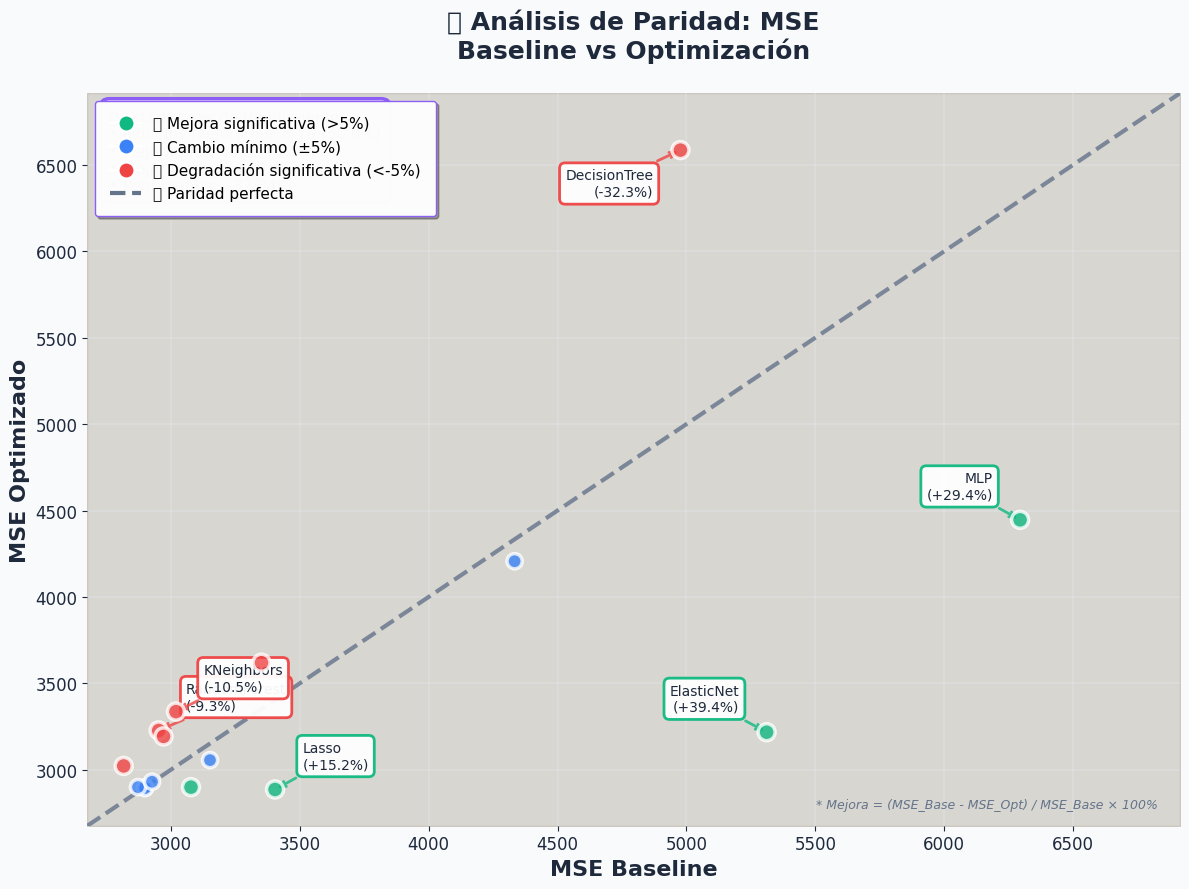

In [7]:
# ===============================================
# 📥 Carga de california.csv (split automático train/test)
# ===============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 👉 Cambia la ruta si está en otra carpeta
PATH = "../../diabetes.csv"

# Intentos típicos de nombre de objetivo
TARGET_CANDIDATES = [
    "MedHouseVal",
]

df = pd.read_csv(PATH)

# ---- Detectar columna objetivo ----
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    # Si no se encuentra, usamos la última columna como objetivo (aviso)
    target_col = df.columns[-1]
    print(f"⚠️ No se encontró una columna objetivo conocida. Uso '{target_col}' (última del CSV).")

# Convertir a numérico por seguridad
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

# ---- Selección de features numéricas ----
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

# ---- Crear X, y ----
X = df[num_cols].copy()
y = df[target_col].values

# ---- Split 75% / 25% ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ---- Imputación simple de NaNs ----
medians = X_train.median(numeric_only=True)
X_train = X_train.fillna(medians)
X_test  = X_test.fillna(medians)

print("✅ Carga completada desde un único CSV.")
print(f"Objetivo (target): {target_col}")
print(f"Features numéricas usadas: {len(num_cols)}")
print("Shapes → X_train:", X_train.shape, "| X_test:", X_test.shape)

# ==========================================================
# 🔥 EVOPT Full Benchmark + Visual Gallery ELEGANTE
# ==========================================================
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings("ignore")

# ===== Imports ML =====
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import (
    LinearRegression, HuberRegressor, Ridge, Lasso, ElasticNet, BayesianRidge
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
)
from sklearn.svm import SVR
from xgboost import XGBRegressor

# ===== Try to import your optimizer from evopt.py =====
EvolutionaryOptimizer = None
try:
    from evopt import EvolutionaryOptimizer as _EO
    EvolutionaryOptimizer = _EO
except Exception as e:
    print("ℹ️ No se pudo importar EvolutionaryOptimizer desde evopt.py (no pasa nada).")
    print("   Detalle:", e)

# ==========================================================
# 🎨 GRÁFICO DE PARIDAD ELEGANTE - FUNCIÓN PRINCIPAL
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

def create_elegant_parity_plot(df_results, metric="MSE"):
    """
    Crea un gráfico de paridad elegante y moderno para comparar MSE Base vs Optimizado
    """
    # Configurar el estilo elegante
    plt.style.use('default')
    sns.set_palette("husl")

    # Configuración de colores elegantes
    colors = {
        'background': '#f8fafc',
        'grid': '#e2e8f0',
        'diagonal': '#64748b',
        'scatter': '#3b82f6',
        'accent': '#8b5cf6',
        'text': '#1e293b',
        'improvement': '#10b981',
        'degradation': '#ef4444'
    }

    base_col = f"{metric}_Base"
    opt_col = f"{metric}_Opt"

    if base_col not in df_results.columns or opt_col not in df_results.columns:
        print(f"❌ Columnas {base_col} o {opt_col} no encontradas")
        return

    # Filtrar valores válidos
    valid_mask = ~(pd.isna(df_results[base_col]) | pd.isna(df_results[opt_col]))
    df_clean = df_results[valid_mask].copy()

    if df_clean.empty:
        print("❌ No hay datos válidos para el gráfico")
        return

    x = df_clean[base_col].values
    y = df_clean[opt_col].values
    models = df_clean["Modelo"].values

    # Crear figura con diseño elegante
    fig, ax = plt.subplots(figsize=(12, 9))
    fig.patch.set_facecolor(colors['background'])
    ax.set_facecolor(colors['background'])

    # Calcular límites con margen
    min_val = min(x.min(), y.min()) * 0.95
    max_val = max(x.max(), y.max()) * 1.05

    # Crear gradiente de colores basado en la mejora
    improvements = 100 * (x - y) / x
    scatter_colors = []
    sizes = []
    for imp in improvements:
        if imp > 5:  # Mejora significativa
            scatter_colors.append(colors['improvement'])
            sizes.append(150)
        elif imp < -5:  # Degradación significativa
            scatter_colors.append(colors['degradation'])
            sizes.append(150)
        else:  # Cambio mínimo
            scatter_colors.append(colors['scatter'])
            sizes.append(120)

    # Scatter plot principal con diseño elegante
    scatter = ax.scatter(x, y,
                        c=scatter_colors,
                        s=sizes,
                        alpha=0.8,
                        edgecolors='white',
                        linewidths=2.5,
                        zorder=5)

    # Línea diagonal de paridad con estilo elegante
    diagonal_line = ax.plot([min_val, max_val], [min_val, max_val],
                           linestyle='--',
                           color=colors['diagonal'],
                           linewidth=3,
                           alpha=0.8,
                           zorder=3,
                           label='Paridad perfecta')

    # Zona de mejora (debajo de la diagonal)
    ax.fill_between([min_val, max_val], [min_val, min_val], [max_val, max_val],
                    alpha=0.15, color=colors['improvement'],
                    label='Zona de mejora', zorder=1)

    # Zona de degradación (encima de la diagonal)
    ax.fill_between([min_val, max_val], [min_val, min_val], [max_val, max_val],
                    alpha=0.15, color=colors['degradation'],
                    label='Zona de degradación', zorder=1)


    # Configurar límites y grid elegante
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.grid(True, alpha=0.4, color=colors['grid'], linewidth=1.2)

    # Etiquetas y título con tipografía elegante
    ax.set_xlabel(f'{metric} Baseline', fontsize=16, fontweight='bold', color=colors['text'])
    ax.set_ylabel(f'{metric} Optimizado', fontsize=16, fontweight='bold', color=colors['text'])
    ax.set_title(f'🎯 Análisis de Paridad: {metric}\nBaseline vs Optimización',
                fontsize=18, fontweight='bold', color=colors['text'], pad=25)

    # Personalizar ticks
    ax.tick_params(colors=colors['text'], labelsize=12)

    # Agregar anotaciones para modelos destacados
    for i, (xi, yi, model) in enumerate(zip(x, y, models)):
        improvement = improvements[i]
        if abs(improvement) > 8:  # Solo anotar mejoras/degradaciones muy significativas
            offset_x = (max_val - min_val) * 0.025
            offset_y = (max_val - min_val) * 0.025

            # Determinar posición de la anotación para evitar solapamiento
            if xi > (min_val + max_val) / 2:
                offset_x = -offset_x
                ha = 'right'
            else:
                ha = 'left'

            if yi > (min_val + max_val) / 2:
                offset_y = -offset_y
                va = 'top'
            else:
                va = 'bottom'

            ax.annotate(f'{model}\n({improvement:+.1f}%)',
                       xy=(xi, yi),
                       xytext=(xi + offset_x, yi + offset_y),
                       fontsize=10,
                       color=colors['text'],
                       ha=ha,
                       va=va,
                       bbox=dict(boxstyle='round,pad=0.4',
                                facecolor='white',
                                edgecolor=scatter_colors[i],
                                alpha=0.95,
                                linewidth=2),
                       arrowprops=dict(arrowstyle='->',
                                     color=scatter_colors[i],
                                     alpha=0.8,
                                     linewidth=2))

    # Leyenda elegante
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['improvement'],
                   markersize=12, label='🟢 Mejora significativa (>5%)', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['scatter'],
                   markersize=12, label='🔵 Cambio mínimo (±5%)', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['degradation'],
                   markersize=12, label='🔴 Degradación significativa (<-5%)', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], linestyle='--', color=colors['diagonal'],
                   linewidth=3, label='📏 Paridad perfecta')
    ]

    ax.legend(handles=legend_elements,
             loc='upper left',
             frameon=True,
             fancybox=True,
             shadow=True,
             framealpha=0.98,
             facecolor='white',
             edgecolor=colors['accent'],
             borderpad=1,
             fontsize=11)

    # Estadísticas del gráfico en una caja elegante
    n_improved = sum(improvements > 0)
    n_total = len(improvements)
    avg_improvement = np.mean(improvements)
    best_improvement = np.max(improvements)
    worst_change = np.min(improvements)

    stats_text = f"""📊 Estadísticas de Rendimiento:
• Modelos mejorados: {n_improved}/{n_total} ({100*n_improved/n_total:.1f}%)
• Mejora promedio: {avg_improvement:+.2f}%
• Mejor mejora: {best_improvement:+.2f}%
• Peor cambio: {worst_change:+.2f}%"""

    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.6',
                     facecolor='white',
                     edgecolor=colors['accent'],
                     alpha=0.98,
                     linewidth=2.5))

    # Remover spines para un look más limpio
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Agregar nota metodológica
    method_note = "* Mejora = (MSE_Base - MSE_Opt) / MSE_Base × 100%"
    ax.text(0.98, 0.02, method_note,
            transform=ax.transAxes,
            fontsize=9,
            style='italic',
            color=colors['diagonal'],
            ha='right',
            va='bottom')

    plt.tight_layout()
    plt.show()

# ==========================================================
# ⚙️ Benchmark end-to-end con gráfico elegante
# ==========================================================
def _safe_percent_improve(base, opt):
    base=float(base); opt=float(opt)
    return 100.0*(base-opt)/base if base!=0 else 0

def run_benchmark_with_elegant_plot():
    # Detectar datos del entorno
    scope=globals()
    X_train=scope.get("X_train"); X_test=scope.get("X_test")
    y_train=scope.get("y_train"); y_test=scope.get("y_test")
    df_results = scope.get("df_results") # Get df_results from previous run
    gp_optimizer = scope.get("gp_optimizer") # Get gp_optimizer from previous run
    X_train_opt = scope.get("X_train_optimized") # Get optimized data from previous run
    X_test_opt = scope.get("X_test_optimized") # Get optimized data from previous run

    if df_results is None:
         raise ValueError("❌ No se encontraron resultados de benchmark anteriores (df_results). Ejecuta la celda anterior primero.")

    # === Mostrar tabla + gráfico elegante ===
    from IPython.display import display
    print("\n✅ Resultados del benchmark (usando resultados anteriores):")
    display(df_results.head(10))

    # Crear el gráfico de paridad elegante
    print("\n🎨 Generando gráfico de paridad elegante...")
    create_elegant_parity_plot(df_results, "MSE")

# ==========================================================
# ▶️ Ejecuta todo con el gráfico elegante:
# ==========================================================
if __name__ == "__main__":
    run_benchmark_with_elegant_plot()

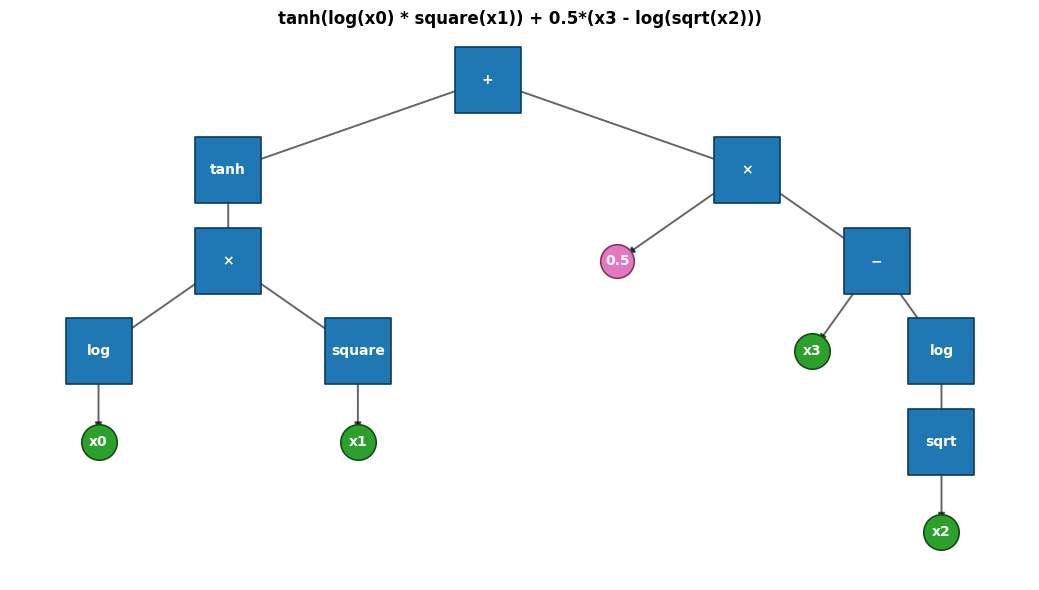

In [8]:
# ================================================
# 🌳 Elegant Function Tree Plot (GP-style)
# - Admite expresiones tipo Python: + - * / **, sin, cos, log, exp, sqrt, etc.
# - Dibuja funciones (rectángulos redondeados) y terminales (óvalos)
# - Puede leer del gp_optimizer.best_trees_[i].to_string() si lo tienes
# ================================================
import ast
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ---------- Config de estilo ----------
NODE_FC_FUNC = "#1f77b4"   # azul
NODE_EC_FUNC = "#0b3c61"
NODE_FC_TERM = "#2ca02c"   # verde
NODE_EC_TERM = "#114d14"
NODE_FC_CONST = "#e377c2"  # rosa para constantes
NODE_EC_CONST = "#7a3d5e"

def _wrap_text(s, width=22):
    s = str(s)
    if len(s) <= width:
        return s
    # Insertar saltos de línea para etiquetas largas
    parts = []
    while len(s) > width:
        parts.append(s[:width])
        s = s[width:]
    if s:
        parts.append(s)
    return "\n".join(parts)

# ---------- Parser de expresiones (Python AST) ----------
# Admite expresiones como:  sin(x0) + 0.5*(x3 - exp(abs(x2)))
# Si tus árboles imprimen funciones con np.sin / numpy.sin también funciona.
_ALLOWED_FUNCS = {
    "sin","cos","tan","exp","log","sqrt","abs",
    "tanh","sinh","cosh",
    "arcsin","arccos","arctan",
    "minimum","maximum","clip"
}

# Para output más bonito en operadores
_OP_SYMBOL = {
    ast.Add: "+", ast.Sub: "−", ast.Mult: "×", ast.Div: "÷",
    ast.Pow: "^", ast.Mod: "mod"
}
_UNARY_SYMBOL = {
    ast.UAdd: "+", ast.USub: "neg"
}

def _get_func_name(node):
    # node puede ser ast.Name o ast.Attribute (np.sin, numpy.sin)
    if isinstance(node, ast.Name):
        return node.id
    if isinstance(node, ast.Attribute):
        return node.attr
    return None

def _format_constant(val):
    try:
        v = float(val)
        # números más "compactos"
        if abs(v) >= 1000 or (abs(v) < 1e-2 and v != 0):
            return f"{v:.2e}"
        return f"{v:.4g}"
    except Exception:
        return str(val)

def parse_expression_to_graph(expr_str, feature_names=None):
    """
    Convierte una cadena de expresión en un DiGraph con metadatos:
      - G.nodes[u]['kind'] in {'func','term','const'}
      - G.nodes[u]['label'] texto a mostrar
    Devuelve (G, root_id).
    """
    if feature_names is None:
        feature_names = set()
    else:
        feature_names = set(feature_names)

    tree = ast.parse(expr_str, mode="eval")  # expresión pura
    G = nx.DiGraph()
    node_id_counter = [0]

    def new_node(label, kind):
        nid = node_id_counter[0]
        node_id_counter[0] += 1
        G.add_node(nid, label=str(label), kind=kind)
        return nid

    def walk(node):
        # Constantes
        if isinstance(node, ast.Constant):
            return new_node(_format_constant(node.value), "const")

        # Variables / nombres
        if isinstance(node, ast.Name):
            if node.id in feature_names or node.id.lower().startswith(("x", "f", "feat")):
                return new_node(node.id, "term")
            # si no está en feature_names, lo etiquetamos como terminal genérico
            return new_node(node.id, "term")

        # Unaria (+x, -x)
        if isinstance(node, ast.UnaryOp):
            op = type(node.op)
            label = _UNARY_SYMBOL.get(op, "unary")
            nid = new_node(label, "func")
            child = walk(node.operand)
            G.add_edge(nid, child)
            return nid

        # Binaria (x + y, x * y, etc.)
        if isinstance(node, ast.BinOp):
            op = type(node.op)
            label = _OP_SYMBOL.get(op, type(node.op).__name__)
            nid = new_node(label, "func")
            left = walk(node.left)
            right = walk(node.right)
            G.add_edge(nid, left)
            G.add_edge(nid, right)
            return nid

        # Llamadas a función: sin(x), np.log(x), ...
        if isinstance(node, ast.Call):
            fname = _get_func_name(node.func) or "func"
            # Mantener si es una función conocida, si no, dejar el nombre tal cual
            label = fname if fname in _ALLOWED_FUNCS or fname else "func"
            nid = new_node(label, "func")
            for arg in node.args:
                cid = walk(arg)
                G.add_edge(nid, cid)
            # ignoramos kwargs visualmente
            return nid

        # Atributo (np.sin) suelto
        if isinstance(node, ast.Attribute):
            fname = node.attr
            return new_node(fname, "term")

        # Tuplas, listas → terminales literales
        if isinstance(node, (ast.Tuple, ast.List)):
            return new_node(str(ast.unparse(node)) if hasattr(ast, "unparse") else "seq", "term")

        # fallback
        return new_node(type(node).__name__, "term")

    root = walk(tree.body)
    return G, root

# ---------- Layout jerárquico (top-down) ----------
def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.18, vert_loc=0, xcenter=0.5):
    """
    Saca posiciones jerárquicas sin Graphviz.
    """
    if not nx.is_tree(G):
        # Hacer un spanning tree sobre el árbol dirigido (desde root)
        T = nx.dfs_tree(G, source=root)
    else:
        T = G

    def _hierarchy_pos(G, root, width=1.0, vert_gap=0.18, vert_loc=0, xcenter=0.5, pos=None, parent=None):
        if pos is None: pos = {root:(xcenter, vert_loc)}
        children = list(G.successors(root))
        if len(children)!=0:
            dx = width/len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos[child] = (nextx, vert_loc - vert_gap)
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                     vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos

    return _hierarchy_pos(T, root, width, vert_gap, vert_loc, xcenter)

# ---------- Dibujado ----------
def draw_expression_tree(expr_str, feature_names=None, title="Expression Tree", node_size=(2200, 650)):
    """
    Dibuja el árbol de la expresión.
    feature_names: lista/conjunto de nombres que deben tratarse como terminales (features).
    node_size: (width_scale, height_scale) para ajustar el tamaño visual relativo.
    """
    G, root = parse_expression_to_graph(expr_str, feature_names=feature_names)
    pos = hierarchy_pos(G, root=root, vert_gap=0.22)

    plt.figure(figsize=(10.5, 6))
    # Aristas
    nx.draw_networkx_edges(G, pos, width=1.4, alpha=0.6)

    # Preparar colecciones por tipo
    func_nodes = [n for n,d in G.nodes(data=True) if d.get("kind")=="func"]
    term_nodes = [n for n,d in G.nodes(data=True) if d.get("kind")=="term"]
    const_nodes = [n for n,d in G.nodes(data=True) if d.get("kind")=="const"]

    # Etiquetas (envueltas)
    labels = {n: _wrap_text(d.get("label","")) for n,d in G.nodes(data=True)}

    # Nodos función (rectángulo redondeado simulado usando draw_networkx_nodes con tamaño)
    nx.draw_networkx_nodes(G, pos, nodelist=func_nodes, node_color=NODE_FC_FUNC,
                           edgecolors=NODE_EC_FUNC, linewidths=1.2, node_size=node_size[0], node_shape="s")
    # Nodos terminal (oval)
    nx.draw_networkx_nodes(G, pos, nodelist=term_nodes, node_color=NODE_FC_TERM,
                           edgecolors=NODE_EC_TERM, linewidths=1.2, node_size=node_size[1])
    # Nodos constante (color distinto)
    nx.draw_networkx_nodes(G, pos, nodelist=const_nodes, node_color=NODE_FC_CONST,
                           edgecolors=NODE_EC_CONST, linewidths=1.2, node_size=int(node_size[1]*0.9))

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight="semibold", font_color="white")

    plt.title(title, weight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ---------- Helper para tu gp_optimizer ----------
def draw_tree_from_optimizer(gp_optimizer, idx=0, feature_names=None, title_prefix="GP Best Tree"):
    """
    Intenta extraer la expresión del árbol idx de gp_optimizer.best_trees_ y dibujarla.
    Si no se puede, prueba con .to_string() del propio optimizador.
    """
    expr = None
    if gp_optimizer is None:
        print("⚠️ gp_optimizer es None.")
        return
    # best_trees_ con objetos que tienen .to_string()
    try:
        best = getattr(gp_optimizer, "best_trees_", None)
        if best and len(best) > idx:
            expr = best[idx].to_string()
    except Exception:
        expr = None
    # fallback
    if expr is None:
        try:
            expr = gp_optimizer.to_string()
        except Exception:
            pass
    if expr is None:
        print("⚠️ No pude extraer una expresión del optimizador.")
        return
    draw_expression_tree(expr, feature_names=feature_names, title=f"{title_prefix} #{idx+1}")
    return expr  # Por si quieres revisarla luego
expr = "tanh(log(x0) * square(x1)) + 0.5*(x3 - log(sqrt(x2)))"
feature_names = [f"x{i}" for i in range(10)]  # o tus nombres reales de columnas
draw_expression_tree(expr, feature_names=feature_names, title=expr)
